In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [ ]:
import os
from pathlib import Path

folder = ""
project_dir = "02_cnn_pt"

base_path = Path("/content/gdrive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/gdrive/My Drive/02_cnn_pt


In [ ]:
import torch
print('pytorch version: {}'.format(torch.__version__))

pytorch version: 2.3.1+cu121


In [ ]:
# !pip install torch==1.1.0 torchvision==0.3.0

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import check_util.checker as checker
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 2.3.1+cu121
GPU 사용 가능 여부: False


In [ ]:
import zipfile
from pathlib import Path

current_path = Path().absolute()
data_path = current_path / "data"
print("현재 디렉토리 위치: {}".format(current_path))
if (data_path / "my_cat_dog").exists():
    print("이미 'data/my_cat_dog' 폴더에 압축이 풀려있습니다. 확인해보세요!")
else:
    with zipfile.ZipFile(str(data_path / "my_cat_dog.zip"), "r") as zip_ref:
        zip_ref.extractall(str(data_path / "my_cat_dog"))
    print("Done!")

현재 디렉토리 위치: /content/gdrive/My Drive/02_cnn_pt
이미 'data/my_cat_dog' 폴더에 압축이 풀려있습니다. 확인해보세요!


In [ ]:
data_dir = './data/my_cat_dog'  # 압축 해제된 데이터셋의 디렉토리 경로

In [ ]:
checker.dataset_check(data_dir)

훈련용 고양이 이미지 개수: 1000
훈련용 강아지 이미지 개수: 1000
검증용 고양이 이미지 개수: 500
검증용 강아지 이미지 개수: 500
테스트용 고양이 이미지 개수: 1000
테스트용 강아지 이미지 개수: 1000


In [ ]:
batch_size = 100
num_epochs = 10
learning_rate = 0.0001

In [ ]:
class CatDogDataset(Dataset):
    def __init__(self, data_dir, mode, transform=None):
        self.all_data = sorted(glob.glob(os.path.join(data_dir, mode, '*', '*')))
        self.transform = transform
        self.mode = mode
    def __getitem__(self, index):
        data_path = self.all_data[index]
        img = Image.open(data_path)
        img = self.transform(img)

        filename = os.path.basename(data_path)
        if filename.startswith('cat'):
          label = 0
        elif filename.startswith('dog'):
          label = 1
        return img, label

    def __len__(self):
        length = len(self.all_data)
        return length


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(120, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([120, 120]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_data = CatDogDataset(data_dir='./data/my_cat_dog', mode='train', transform=data_transforms['train'])
val_data = CatDogDataset(data_dir='./data/my_cat_dog', mode='val', transform=data_transforms['val'])
test_data = CatDogDataset(data_dir='./data/my_cat_dog', mode='test', transform=data_transforms['val'])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv 구현
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        # self.fc 구현
        self.fc1 = nn.Linear(128*5*5,512)
        self.fc2 = nn.Linear(512,2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def train(num_epochs, model, data_loader, criterion, optimizer, saved_dir, val_every, device):
    print('Start training..')
    best_loss = 9999999
    for epoch in range(num_epochs):
        for i, (imgs, labels) in enumerate(data_loader):
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, argmax = torch.max(outputs, 1)
            accuracy = (labels == argmax).float().mean()

            if (i+1) % 3 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
                    epoch+1, num_epochs, i+1, len(data_loader), loss.item(), accuracy.item() * 100))

        if (epoch + 1) % val_every == 0:
            avrg_loss = validation(epoch + 1, model, val_loader, criterion, device)
            if avrg_loss < best_loss:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, saved_dir)

In [ ]:
def validation(epoch, model, data_loader, criterion, device):
    print('Start validation #{}'.format(epoch) )
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        cnt = 0
        for i, (imgs, labels) in enumerate(data_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total += imgs.size(0)
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item()
            total_loss += loss
            cnt += 1
        avrg_loss = total_loss / cnt
        print('Validation #{}  Accuracy: {:.2f}%  Average Loss: {:.4f}'.format(epoch, correct / total * 100, avrg_loss))
    model.train()
    return avrg_loss

In [ ]:
def test(model, data_loader, device):
    print('Start test..')
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (imgs, labels) in enumerate(data_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)

            _, argmax = torch.max(outputs, 1)
            total += imgs.size(0)
            correct += (labels == argmax).sum().item()

        print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))
    model.train()

In [ ]:
def save_model(model, saved_dir, file_name='best_model.pt'):
    os.makedirs(saved_dir, exist_ok=True)
    check_point = {
        'net': model.state_dict()
    }
    output_path = os.path.join(saved_dir, file_name)

    torch.save(check_point, output_path)

In [ ]:
torch.manual_seed(7777) # 일관된 weight initialization을 위한 random seed 설정

model = SimpleCNN()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model = model.to(device)
val_every = 1
saved_dir = './saved/SimpleCNN'

In [ ]:
train(num_epochs, model, train_loader, criterion, optimizer, saved_dir, val_every, device)

Start training..
Epoch [1/10], Step [3/20], Loss: 0.6731, Accuracy: 54.00%
Epoch [1/10], Step [6/20], Loss: 0.7095, Accuracy: 54.00%
Epoch [1/10], Step [9/20], Loss: 0.6781, Accuracy: 57.00%
Epoch [1/10], Step [12/20], Loss: 0.6586, Accuracy: 63.00%
Epoch [1/10], Step [15/20], Loss: 0.5827, Accuracy: 70.00%
Epoch [1/10], Step [18/20], Loss: 0.6287, Accuracy: 67.00%
Start validation #1
Validation #1  Accuracy: 50.20%  Average Loss: 0.7338
Best performance at epoch: 1
Save model in ./saved/SimpleCNN
Epoch [2/10], Step [3/20], Loss: 0.5681, Accuracy: 73.00%
Epoch [2/10], Step [6/20], Loss: 0.5944, Accuracy: 71.00%
Epoch [2/10], Step [9/20], Loss: 0.5953, Accuracy: 67.00%
Epoch [2/10], Step [12/20], Loss: 0.5556, Accuracy: 75.00%
Epoch [2/10], Step [15/20], Loss: 0.5161, Accuracy: 74.00%
Epoch [2/10], Step [18/20], Loss: 0.5099, Accuracy: 76.00%
Start validation #2
Validation #2  Accuracy: 69.80%  Average Loss: 0.5729
Best performance at epoch: 2
Save model in ./saved/SimpleCNN
Epoch [3/10

In [ ]:
model_path = './saved/SimpleCNN/best_model.pt'
# model_path = './saved/pretrained/SimpleCNN/best_model.pt' # 모델 학습을 끝까지 진행하지 않은 경우에 사용
model = SimpleCNN().to(device)   # 아래의 모델 불러오기를 정확히 구현했는지 확인하기 위해 새로 모델을 선언하여 학습 이전 상태로 초기화

checkpoint = torch.load(model_path,map_location = device)
state_dict = checkpoint['net']
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
test(model, test_loader, device)

Start test..
Test accuracy for 2000 images: 76.35%


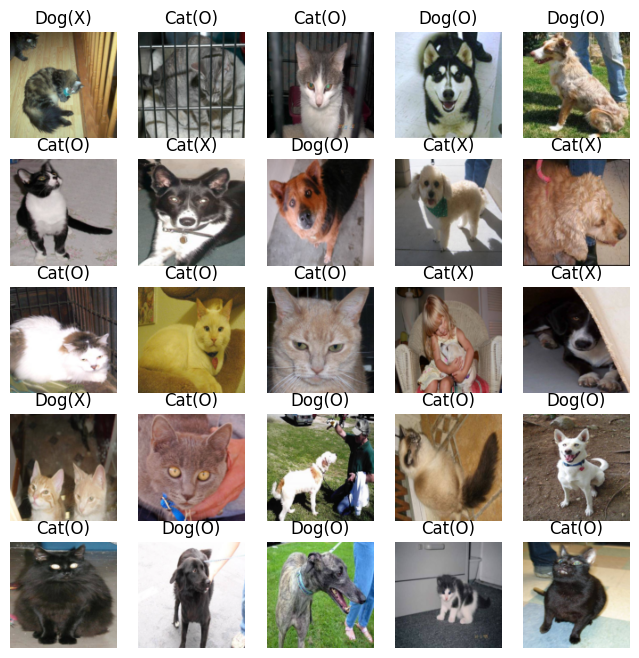

In [ ]:
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

model.eval()
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device)

    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = argmax.item()
    label = test_data[data_idx][1]

    fig.add_subplot(rows, columns, i)
    pred_title = 'Cat' if pred == 0 else 'Dog'
    if pred == label:
        plt.title(pred_title + '(O)')
    else:
        plt.title(pred_title + '(X)')
    plot_img = test_data[data_idx][0]
    # 이미지를 normalization 이전 상태로 되돌리는 작업
    plot_img[0, :, :] = plot_img[0, :, :] * std[0] + mean[0]
    plot_img[1, :, :] = plot_img[1, :, :] * std[1] + mean[1]
    plot_img[2, :, :] = plot_img[2, :, :] * std[2] + mean[2]
    plot_img = transforms.functional.to_pil_image(plot_img)
    plt.imshow(plot_img)
    plt.axis('off')
plt.show()

In [ ]:
new_model = torchvision.models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 99.9MB/s]


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0 ), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_data = CatDogDataset(data_dir='./data/my_cat_dog', mode='train', transform=data_transforms['train'])
val_data = CatDogDataset(data_dir='./data/my_cat_dog', mode='val', transform=data_transforms['val'])
test_data = CatDogDataset(data_dir='./data/my_cat_dog', mode='test', transform=data_transforms['val'])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [ ]:
for param in new_model.parameters():
    param.requires_grad = False

num_ftrs = new_model.fc.in_features

new_model.fc = nn.Linear(num_ftrs, 2)
criterion = nn.CrossEntropyLoss()
new_model = new_model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

val_every = 1
saved_dir = './saved/ResNet50'

In [ ]:
train(num_epochs, new_model, train_loader, criterion, optimizer, saved_dir, val_every, device)

Start training..
Epoch [1/10], Step [3/20], Loss: 0.6993, Accuracy: 48.00%
Epoch [1/10], Step [6/20], Loss: 0.7289, Accuracy: 40.00%
Epoch [1/10], Step [9/20], Loss: 0.6804, Accuracy: 56.00%
Epoch [1/10], Step [12/20], Loss: 0.7021, Accuracy: 50.00%
Epoch [1/10], Step [15/20], Loss: 0.7065, Accuracy: 51.00%
Epoch [1/10], Step [18/20], Loss: 0.6916, Accuracy: 45.00%
Start validation #1
Validation #1  Accuracy: 48.90%  Average Loss: 0.7149
Best performance at epoch: 1
Save model in ./saved/ResNet50
Epoch [2/10], Step [3/20], Loss: 0.7373, Accuracy: 43.00%
Epoch [2/10], Step [6/20], Loss: 0.7042, Accuracy: 49.00%
Epoch [2/10], Step [9/20], Loss: 0.6819, Accuracy: 57.00%
Epoch [2/10], Step [12/20], Loss: 0.7072, Accuracy: 49.00%
Epoch [2/10], Step [15/20], Loss: 0.6832, Accuracy: 55.00%
Epoch [2/10], Step [18/20], Loss: 0.7115, Accuracy: 46.00%
Start validation #2
Validation #2  Accuracy: 48.80%  Average Loss: 0.7094
Best performance at epoch: 2
Save model in ./saved/ResNet50
Epoch [3/10],

In [ ]:
model_path = './saved/ResNet50/best_model.pt'
# model_path = './saved/pretrained/ResNet50/best_model.pt' # 모델 학습을 끝까지 진행하지 않은 경우에 사용

checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint['net']
new_model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
test(new_model, test_loader, device)

Start test..
Test accuracy for 2000 images: 51.10%


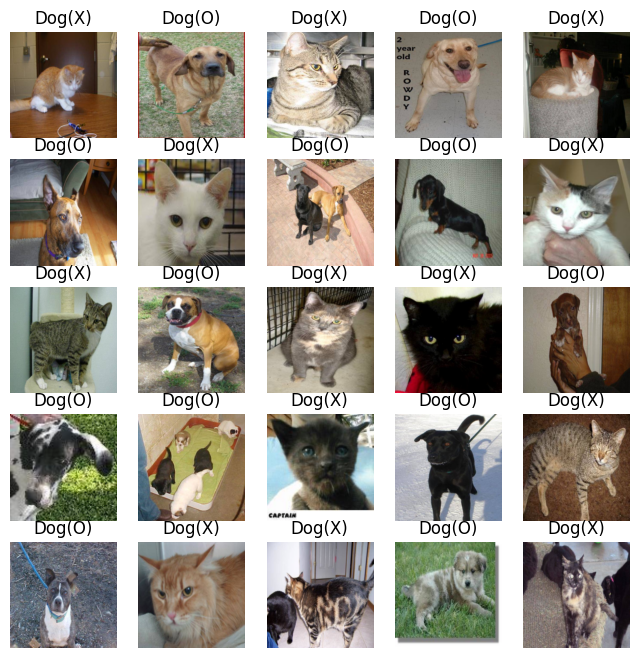

In [ ]:
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

model.eval()
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device)
    '''
    unsqueeze()를 통해 입력 이미지의 shape을 (1, 28, 28)에서 (1, 1, 28, 28)로 변환.
    모델에 들어가는 입력 이미지의 shape은 (batch_size, channel, width, height) 되어야 함에 주의하세요!
    '''
    output = new_model(input_img)
    _, argmax = torch.max(output, 1)
    pred = argmax.item()
    label = test_data[data_idx][1]

    fig.add_subplot(rows, columns, i)
    pred_title = 'Cat' if pred == 0 else 'Dog'
    if pred == label:
        plt.title(pred_title + '(O)')
    else:
        plt.title(pred_title + '(X)')
    plot_img = test_data[data_idx][0]
    # 이미지를 normalization 이전 상태로 되돌리는 작업
    plot_img[0, :, :] = plot_img[0, :, :] * std[0] + mean[0]
    plot_img[1, :, :] = plot_img[1, :, :] * std[1] + mean[1]
    plot_img[2, :, :] = plot_img[2, :, :] * std[2] + mean[2]
    plot_img = transforms.functional.to_pil_image(plot_img)
    plt.imshow(plot_img)
    plt.axis('off')
model.train()
plt.show()

- Dataset class를 우리가 가진 데이터셋에 맞게 customize 하여 정의할 수 있다.
- CNN을 설계하고 이미지 분류기를 학습시킬 수 있다.
- 학습된 모델을 저장하고 불러올 수 있다.
- 데이터, 리소스, 시간이 부족한 상황에서 전이학습을 사용하여 이를 극복할 수 있다.

---